# Intro to the API and Plotting

For definitions of the technical terminology used throughout this and following notebooks please see the notebook titled Glossary. You will also find all the information on the locations, devices, and properties you will need to interact with this tutorial.

In this tutorial you will learn how to plot data from the ONC database. To do this, we will:

- Set up our programming environment and connect to the ONC API

- Define a query to ask the API

- Request data from the ONC database using the API

- Explore the content and structure of the API response

- Isolate and load your chosen property data into a DataFrame

- Plot data from the DataFrame

Key words: inputs/parameters, API, DataFrame, library, token, function,

### Text and code blocks

Throughout this notebook you will see text blocks (like this one) and code blocks (like the shaded one below). Code blocks contain Python commands that you can run by clicking the little blue play button at the top of each code block (appears when you hover your cursor over the block). 

You will also see some green text following the character "#". These lines of green text are comments about the code (to help you understand it), and are ignored by Python.

In [1]:
print ("Hello world!") # This is a simple Python command to print the words "Hello world!"

Hello world!


### Interactivity

> Look out for these blocks because they contain instructions for interacting with this notebook!

## 1. Set Up Programming Environment

We want to be able to run a notebook multiple times over a period and still produce the same results. To make this possible, we must ensure that the software environment used to run the notebook is consistent.

A key part of the environment is the set of libraries the notebook depends on. 

As mentioned in the Glossary, a library contains code that adds extra features to Python. We'll be using libraries for tasks like connecting to online data sources (ONC's client library), helping with data analysis (pandas) and with data visualization (matplotlib).

To ensure the correct libraries are available, projects commonly include a file called requirements.txt. This file lists the Python libraries (and, in some cases, their versions) that are required for the notebook to run correctly. By using the libraries listed in this file, the same environment can be recreated on different systems or at different times.

Thus, the first step in setting our environment is to install the libraries from our requirements.txt file. This brings the code into our workspace so that Python can find it. You can view this file in the left hand panel under "Files".

The code block below installs in the libraries listed in our requirements.txt file.

In [2]:
!pip install -r ./requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


pip stands for "Python installs packages" and is the standard package manager for Python, meaning it handles all external libraries.

Next, we need to import the libraries we want to use in this notebook. Importing a library loads the installed code into our program so we can use it.

The code below imports the onc library. We will import other libraries as we need them throughout this notebook, so keep an eye out for similar line of code.

In [3]:
import onc # import the ONC client library

### 1.1 Connect to the API

Using the onc client library we can connect to the API with our unique and individual token. Recall that an API is like a server in a restaurant and a database in like a kitchen— you tell the server what you want, they tell the kitchen, and then they deliver your food from the kitchen to you when it's ready. 

Your token lets the API know who you are and gives you permission to access the data. You can find your token by logging into https://data.oceannetworks.ca/, viewing your profile, and clicking the Web Services API tab.

<img src="(2) Plotting Tutorial files/onc_token_plotting_tutorial.png" width="" align="" />

Students should retrieve their own tokens now.

> Enter your token below.

In [4]:
my_onc = onc.ONC(token="YOUR TOKEN HERE") # INTERACTIVE: Enter your token here (in quotes).

Notice the we use the dot in onc.ONC above to access the ONC class from within the onc library. The ONC class is a blueprint for creating a client to communicate with the ONC API. We create an instance of this class and call it my_onc. This will be important when we are ready to ask the API for data.

If you're lost with this vocabulary, take a minute to head to the Glossary to review.

## 2. Define Query

Now that our basic environment is set up, we must define what it is we want to plot. That means choosing a locationCode, deviceCategoryCode, and time frame, just like with the OpenAPI.

These selections are called parameters, and they will form the overall query that we ask the API. 

Thus, we define our parameters according to what we are interested in. 

### 2.1 Define Parameters

Initially, we will look at CTD data from the Folger Deep (FGPD) platform for 10 months in 2025. Later, you will replace these parameters to access and plot different data.

> Define your parameters in the following block of code (lines 3-6).

In [ ]:
# INTERACTIVE: Modify the parameter values to the right of the semicolons. Use quotes. Reference the comments (in green) for default values.
params = {
    "locationCode": "LOCATION CODE",            # "FGPD" is the location code name for ONC's Folger Deep platform
    "deviceCategoryCode": "DEVICE CAT CODE",    # "CTD" is the device category code for a Conductivity-Temperature-Depth instrument
    "dateFrom": "START DATE (ISO 8601 UTC)",    # "2025-01-01T00:00:00.000Z" is the starting date for the data you want to plot
    "dateTo": "END DATE (ISO 8601 UTC)"         # "2025-11-01T20:00:00.000Z" is the ending date for the data you want to plot
}

Note this is UTC time NOT Pacific Standard Time.

### 2.2 Set Subsampling Depending on Time Series Length

Next, the program checks if your requested time range is over 24 hours. Since the API limits responses to 100,000 lines (about 1.5 days at 1 observation per second), this code uses subsampling for longer requests by setting the resample period parameter based on the duration.

In [7]:
from datetime import datetime # Import library that recognizes your defined times as real dates in time

# Convert string inputs defined in the params above to datetime objects
start_time = datetime.fromisoformat(params['dateFrom'].replace("Z", "+00:00"))
end_time = datetime.fromisoformat(params['dateTo'].replace("Z", "+00:00"))

# Calculate the duration in hours (there are 3600 seconds in an hour)
duration_hours = (end_time - start_time).total_seconds() / 3600

# Check length of time series we want to request. Resample the data based on length of requested data 
if duration_hours > 2190: # If greater than 3 months
    resample = 1800
elif duration_hours > 24: # If greater than 24 hours
    resample = 900
else:
    resample = None

# Set resample paramters if necessary
if resample:
    params["metadata"] = "minimum"
    params["qualityControl"] = "clean"
    params["resamplePeriod"] = resample
    params["resampleType"] = "avg"

### 2.3 Preview Final Parameters

In the code block below the command print() shows all the parameters defined above as name: value pairs— that is, the name of the parameter followed by a semi colon, followed by the value it represents. We can see them all listed in the box below. These are the final parameters that we will use to request data in the next step. 

In [8]:
print(params) # Preview the parameters

{'locationCode': 'FGPD', 'deviceCategoryCode': 'CTD', 'dateFrom': '2025-01-01T00:00:00.000Z', 'dateTo': '2025-11-01T20:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}


## 3. Request Data

Now that we have the ONC library and have connected to the ONC API, we can use the code written in the library. This code is organized into functions— small, reusable blocks of code that perform specific tasks— like getScalardata(), which we use below. 

We will now request data via the API by using our parameters with the getScalardata() function, which returns scalar data according to the parameters we provide. The following code block makes the request and handles any errors that might arise from trying to run this function.

> Enter the function call below on line 4.

In [ ]:
from requests.exceptions import HTTPError # Importing a library to handle errors from the API

try:
    api_response = my_onc."FUNCTION HERE"(params) # INTERACTIVE: Make the getScalardata request for our predefined parameters

except HTTPError as e: # Handle any issues with request and stop program
    print(f"Read the error description(s) below and adjust your input parameters accordingly.")
    print(e)
    raise SystemExit

The API will then send back a JSON formatted response according to your parameters— in Python we can treat it like a dictionary. JSON just refers to the 'shape' the data is formatted in and how we can access different parts of it, but now would be a good time to review the Glossary if you're feeling lost.

The code below imports a the json library which we will use to format the API response so it's easier to read.

In [10]:
import json # Import the json library

## 4. Inspect the API Response

As a reminder, you are looking for the data collected by the device you defined in your parameters. 

The structure of the API response, including the data structure types like dictionary or list, and the specific names of each section in the response, are important because this dictate how we isolate and access different parts of it.

### 4.1 Preview the Sections of the API Response

The code below iterates through the API response dictionary, where each key is a section title and each value is the type of data in that section. It then builds a new dictionary mapping each section name to the type of its value. We then print this dictionary, and format it using the json dumps function, which gives an overview of the API response structure.

In [11]:
sections = {} # Create a dictionary to hold the section names and types

# Loop over each key-value pair in the top-level of the API response
for key, value in api_response.items():

    # Store each result using the format "section title": "data type"
    sections[key] = str(type(value))

print(json.dumps(sections, indent=2)) # Print the result in a readable format

{
  "citations": "<class 'list'>",
  "messages": "<class 'list'>",
  "next": "<class 'NoneType'>",
  "parameters": "<class 'dict'>",
  "qaqcFlagInfo": "<class 'dict'>",
  "queryUrl": "<class 'str'>",
  "sensorData": "<class 'list'>"
}


From these section titles, notice sensorData. This section contains the data you need for plotting.

### 4.2 Preview the sensorData Section

Consider the sensorData section mentioned above. We see in the code output above that the sensorData section is a list. 

The code below further iterates through the sensorData list, and builds a new dictionary mapping the element at each position to its data type. Again, we print this dictionary to get an overview of the sensorData structure.

In [12]:
section = "sensorData" # NOTE: This code will work for any section shown in section 4.1 that is a list

type_preview = {} # Create a dictionary to hold each element in the list and it's data type

# Loop over each item in the sensorData list, keeping track of the index
for i, item in enumerate(api_response[section]):

    # Store each result using the format "position in list": "data type"
    type_preview[f"{section}[{i}]"] = str(type(item))

print(json.dumps(type_preview, indent=2)) # Print the result in a readable format

{
  "sensorData[0]": "<class 'dict'>",
  "sensorData[1]": "<class 'dict'>",
  "sensorData[2]": "<class 'dict'>",
  "sensorData[3]": "<class 'dict'>",
  "sensorData[4]": "<class 'dict'>",
  "sensorData[5]": "<class 'dict'>",
  "sensorData[6]": "<class 'dict'>",
  "sensorData[7]": "<class 'dict'>"
}


Notice how each element in the list is a dictionary. We will refer to these dictionaries as data entries. Recall that we are looking for the data collected by the device we defined in our parameters in section 2.1. Each data entry contains the information for a single property collected by this device.

### 4.3 Preview a Data Entry

The code below inspects a single data entry in the sensorData section. It iterates through the keys of that data entry dictionary and, for any values that are themselves dictionaries, iterates one level deeper to show the types of nested values.

In [34]:
preview = {}  # Create a dictionary to hold the data entry, its contents, and corresponding data types

# Pick the first data entry in the sensorData list
data_entry = api_response[section][0]

data_entry_preview = {}  # Create a dictionary to hold the key-type mapping for this data entry

# Outer loop: iterate over each key-value pair in the data entry
for key, value in data_entry.items():
    # If the value is a dictionary, inspect its keys one level deeper
    if isinstance(value, dict):
        nested_preview = {}  # Create a dictionary to hold the nested key-type mapping
        # Inner loop: iterate over each key-value pair in the nested dictionary
        for nested_key, nested_value in value.items():
            # Store each nested key and the type of its value
            nested_preview[nested_key] = str(type(nested_value))
        # Add the nested preview under the current key
        data_entry_preview[key] = nested_preview
    else:
        # Otherwise, just store the type of the value
        data_entry_preview[key] = str(type(value))

# Add the data entry preview to the main preview dictionary
# Store the entry using the format "position in sensorData list": "data type / nested structure"
preview[f"{section}[0]"] = data_entry_preview

print(json.dumps(preview, indent=2)) # Print the result in a readable format

{
  "sensorData[0]": {
    "actualSamples": "<class 'int'>",
    "data": {
      "counts": "<class 'list'>",
      "maxQuality": "<class 'list'>",
      "maxTimes": "<class 'list'>",
      "minQuality": "<class 'list'>",
      "minTimes": "<class 'list'>",
      "qaqcFlags": "<class 'list'>",
      "sampleTimes": "<class 'list'>",
      "values": "<class 'list'>"
    },
    "outputFormat": "<class 'str'>",
    "propertyCode": "<class 'str'>",
    "sensorCategoryCode": "<class 'str'>",
    "sensorCode": "<class 'str'>",
    "sensorName": "<class 'str'>",
    "unitOfMeasure": "<class 'str'>"
  }
}


This general structure of a data entry will be important to understand when it's time to extract the data and metadata we need for plotting.

### 4.4 Explore Available Properties 

Now that we understand the structure of the API response, we can focus on the contents of it.

One approach to view the contents of these data entries is to convert the entire sensorData section of the API response into a DataFrame using the pandas library DataFrame function. This will show us the actual properties available at your chosen device and location.

In [ ]:
import pandas # Import the pandas library for data handling; we will refer to it as "pd"

> Enter a section of the API response to preview. Before moving on to step 5, enter 'sensorData' as your section.

In [ ]:
sensorData_df = pd.DataFrame(api_response['ENTER SECTION HERE']) # INTERACTIVE: Enter a section of the API response to convert a DataFrame. The DataFrame will be named "sensorData_df".

The code below displays the data frame.

In [15]:
sensorData_df  # Display the DataFrame

,actualSamples,data,outputFormat,propertyCode,sensorCategoryCode,sensorCode,sensorName,unitOfMeasure
0,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,conductivity,conductivity,cond,Conductivity,S/m
1,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,density,density,density,Density,kg/m3
2,14547,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,pressure,pressure,Pressure,Pressure,decibar
3,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,salinity,salinity,salinity,Practical Salinity,psu
4,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,sigmat,sigma_t,sigmaT,Sigma-t,kg/m3
5,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,sigmatheta,sigma_theta,SIGMA_THETA,Sigma-theta (0 dbar),kg/m3
6,14187,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,soundspeed,sound_speed,Sound_Speed,Sound Speed,m/s
7,14547,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,seawatertemperature,temperature,Temperature,Temperature,C


If you used sensorData, then the above DataFrame should have a row for each property, for example, conductivity. You should also see the corresponding numbers of samples, sensor name, units of measure, sensor categories, sensor codes and output formats.

## 5. Create a DataFrame for Your Chosen Property

First, look at the available property codes in the response, as visible in the propertyCode column above. Choose one of these property codes to further explore.

### 5.1 Isolate Data Entry for Property in the API Response

> Enter your chosen property code in the code block below (line 1).

The code block below isolates the data entry for your chosen property using the propertyCode. This includes the data points collected by the sensor, sample times, quality assurance and control flags, and metadata. 

In [ ]:
chosen_property= "YOUR PROPERTY HERE" # INTERACTIVE: Enter your chosen property code here (in quotes).

try: 
    # Isolate the correct data entry for your chosen property
    if chosen_property == "oxygen": # If interested in oxygen, select corrected oxygen
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property and dic["sensorCategoryCode"] == "oxygen_corrected")
    else:
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property)

except StopIteration: # Handle invalid property code
    print(f"Chosen property '{chosen_property}' not found.\n"
    f"Please confirm that your chosen property is avaliable at your selected location and device.")

Remember that the API response is JSON formatted, which looks and behaves like a dictionary. This is why we access sections of the response using the same syntax as we do with dictionaries: value = dictionary["key"].

### 5.2 Extract Property Data and Metadata from the Data Entry

The program then takes the isolated data entry and extracts relevant information, including: 

-  'sampleTimes' and 'values' which contain the actual data to plot

-  'sensorName', 'unitOfMeasure' and 'locationCode' which contain the meta data we will use to label the plot

In [17]:
# Isolate 'sampleTimes' and 'values' to make the plot
timestamps = data_entry["data"]["sampleTimes"]
values = data_entry["data"]["values"]

# Isolate 'sensorName', 'unitOfMeasure' and 'locationCode' to label the plot
unit = data_entry["unitOfMeasure"]
name = data_entry["sensorName"]
location_code = api_response["parameters"]["locationCode"]

Notice that the sampleTimes section was isolated and assigned to a variable called 'timestamps'. Naming variables should be done with the goal of providing clarity and following the best practices of the language you're programming in.

### 5.3 Put Property Data in a DataFrame 

The following code then puts this information into a new DataFrame called prop_df (short for property_dataframe).

In [18]:
# Create DataFrame containing timestamps and observation values for each timestamp
prop_df = pd.DataFrame({
    # We set the column label on the left : and the values on the right
    "time": pd.to_datetime(timestamps),   # Column label = "time", values = timestamps converted to datetime objects
    chosen_property: values               # Column label = your chosen property, values = recorded observations
})

The code below displays the data frame.

In [19]:
prop_df # Display the DataFrame

,time,salinity
0,2025-01-01 00:15:00+00:00,31.788414
1,2025-01-01 00:45:00+00:00,31.815066
2,2025-01-01 01:15:00+00:00,31.847470
3,2025-01-01 01:45:00+00:00,31.863941
4,2025-01-01 02:15:00+00:00,31.879453
...,...,...
14627,2025-11-01 17:45:00+00:00,32.707586
14628,2025-11-01 18:15:00+00:00,32.690917
14629,2025-11-01 18:45:00+00:00,32.682629
14630,2025-11-01 19:15:00+00:00,32.667434


## 6. Plot Your Chosen Property vs Time

Using the DataFrame we generated for your chosen property above, you can now plot a property vs time visualization. We will use the library called matplotlib to generate the data plot.

Depending on whether you chose to plot a long or short time series, one of the two code blocks below will execute; they vary slightly in their labeling of dates and times.

Note that we set up subsampling for long time series by using the parameter 'resample' in the API request (section 2.2). This parameter is also how the program knows which block to execute.

In [20]:
# Import libraries for plotting and handling dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

> Change the title (line 15) as indicated on lines 9-12 of the code blocks below.

### 6.1 Short Time Series

In [21]:
if not resample: # We use the resample parameter for long time series, thus this code does nothing for a long time series.

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the DataFrame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Below we set our title and labels using formatted strings - 'f strings'. 
    # This lets us insert variable values (like name, location_code, or date) 
    # directly into the text using {braces}.
    # These variables were defined in section 5.2.

    # Set plot title
    plt.title(f"YOUR TITLE HERE" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
            f"\n{start_time.strftime('%b %d, %Y')}")

    # Set axis labels
    plt.xlabel("Time (HH:MM UTC)", labelpad=10) # 'labelpad': spacing in points from the Axes bounding box including ticks and tick labels
    plt.ylabel(f"{name} ({unit})", labelpad=10) 

    # Format x-axis dates according to ISO format: HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) # "%H:%M" displays time as hours and minutes for short time series

    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # This last line generates your plot
    plt.show()

### 6.2 Long Time Series

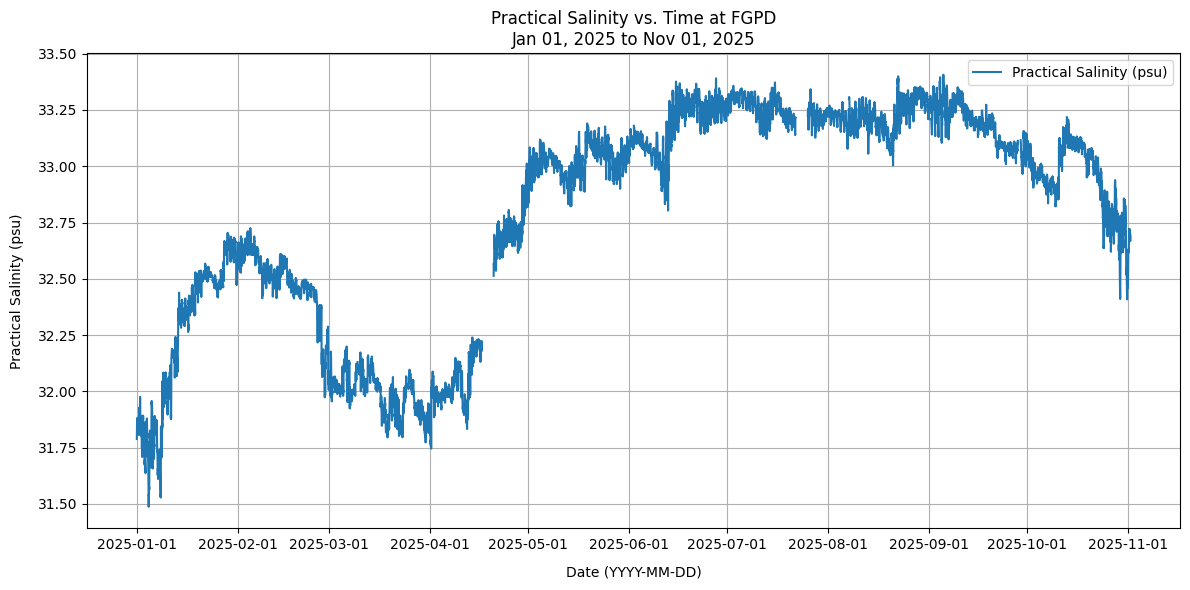

In [22]:
if resample: # Since we use the resample parameter for long time series, the program will use this code to plot.

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the DataFrame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Below we set our title and labels using formatted strings - 'f strings'. 
    # This lets us insert variable values (like name, location_code, or date) 
    # directly into the text using {braces}.
    # These variables were defined in section 5.2.

    # Set plot title
    plt.title(f"YOUR TITLE HERE" # INTERACTIVE: Modify your title here (in quotes). Use '{}' around variables like 'name' to display them.
            f"\n{start_time.strftime('%b %d, %Y')} to {end_time.strftime('%b %d, %Y')}")
    
    # Set axis labels
    plt.xlabel("Date (YYYY-MM-DD)", labelpad=10) # 'labelpad' spacing in points from the Axes bounding box including ticks and tick labels
    plt.ylabel(f"{name} ({unit})", labelpad=10)

    # Format x-axis dates according to ISO format: YYYY-MM-DD
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d")) # "%Y-%m-%d" displays time as year, month, and day for long time series
    
    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # This last line generates your plot
    plt.show()

## 7. Challenges

Now that you have walked through this plotting tutorial, go back and modify the code to change some parameters to plot something different. For example:

- Plot a different time period (section 2.1 - try January through August 2021).

- Plot a different instrument, for example: "locationCode": "FGPD.O2" instead of "FGPD" and "deviceCategoryCode": "OXYSENSOR" instead of "CTD"  (section 2.1).

### 7.1 Troubleshooting

- Check spelling and accuracy of your replaced parameters. Also check capitalization and case sensitivity (match what you found in the original code).

- Look for any missing brackets, quotation marks or commas.

- Check your plots to make sure you plotted what you intended to plot. Also check your plot legend, title, axes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ade8ed14-1fe0-4dd8-a068-473cbde195a5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>